# ExtraFerm Tutorial

This notebook demonstrates how to use ExtraFerm to compute quantum circuit outcome probabilities. We will cover three main approaches:

1. **Raw Estimate Algorithm**: Calculate probability estimates given an additive error, failure probability, and probability upper bound. In practice, this algorithm is highly parallel and best for estimating large quantities of probabilities. 
2. **Estimate Algorithm**: Calculate probability estimates given only an additive error and failure probability. In practice, this algorithm is best for estimating a small number of probabilities to high accuracy.
3. **Exact Calculation**: Compute exact probabilities (for small circuits). This algorithm is practical for circuits in the regime of <20 controlled-phase gates.

## Circuit Construction

We'll start by creating a simple 10-qubit quantum circuit containing mostly matchgates and a few non-matchgates. This circuit will serve as our example throughout the tutorial.

**Circuit Components:**
- **Initial state**: Hamming weight of 4 (4 qubits in |1⟩ state)
- **Matchgates**: XX+YY gates and phase gates
- **Non-matchgates**: Controlled-phase gates

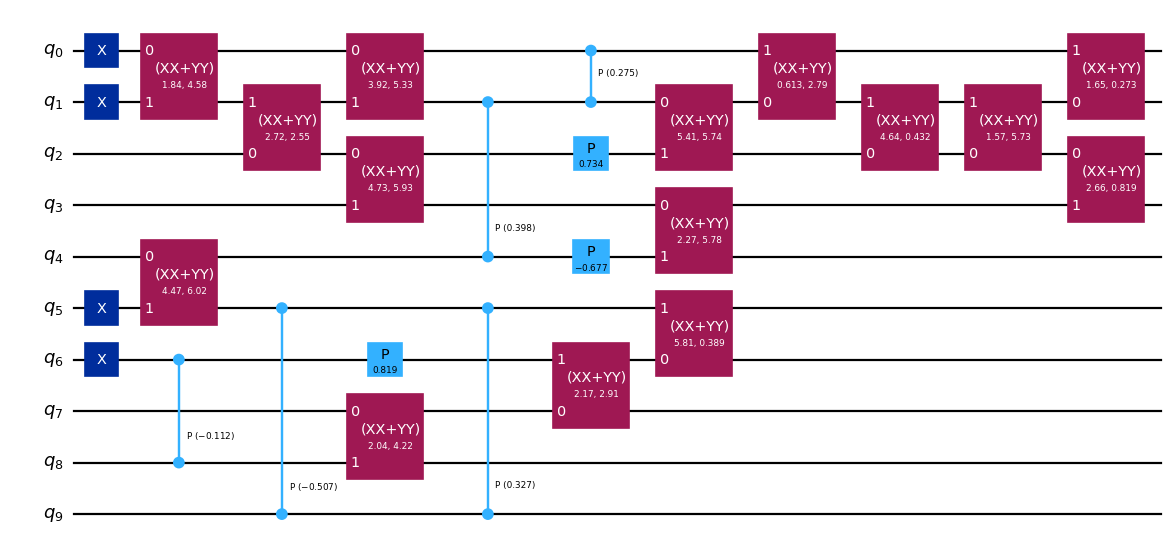

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import XXPlusYYGate

rng = np.random.default_rng(seed=999)

# Initialize a 10 qubit circuit.
qc = QuantumCircuit(10)

# Give it an initial Hamming weight of 4.
qc.x([0, 1, 5, 6])

# Add some XX+YY gates (matchgates)
for _ in range(5):
    q0, q1 = rng.integers(0, 9), rng.integers(0, 9)
    while q0 == q1 or abs(q0 - q1) != 1:
        q0, q1 = rng.integers(0, 9), rng.integers(0, 9)
    theta = rng.uniform(0, 2*np.pi)
    beta = rng.uniform(0, 2*np.pi)
    qc.append(XXPlusYYGate(theta, beta), [q0, q1])

# Add some controlled-phase gates (non-matchgates)
for _ in range(5):
    ctrl, tgt = rng.choice(10, size=2, replace=False)
    theta = rng.uniform(-np.pi/5, np.pi/5)
    qc.cp(theta, ctrl, tgt)

# Add some phase gates (more matchgates)
for q in rng.choice(10, size=3, replace=False):
    theta = rng.uniform(-np.pi/3, np.pi/3)
    qc.p(theta, q)

# Add more XX+YY gates (more matchgates)
for _ in range(10):
    q0, q1 = rng.integers(0, 9), rng.integers(0, 9)
    while q0 == q1 or abs(q0 - q1) != 1:
        q0, q1 = rng.integers(0, 9), rng.integers(0, 9)
    theta = rng.uniform(0, 2*np.pi)
    beta = rng.uniform(0, 2*np.pi)
    qc.append(XXPlusYYGate(theta, beta), [q0, q1])

qc.draw("mpl", scale=.8, fold=-1)

## Ground Truth Calculation

Since our circuit is small (10 qubits), we can use Qiskit's statevector simulation to compute the exact probabilities of all bitstrings. This will serve as our ground truth for comparing the accuracy of our simulator's estimates.

## Circuit Extent Analysis

The **extent** is a key metric that measures the computational complexity of our circuit. It scales exponentially with the magnitude of the controlled-phase gate angles, making it a crucial factor in determining simulation feasibility.

In [3]:
from extraferm.utils import extract_circuit_data
data = extract_circuit_data(qc)
extent = data.extent
print('Extent:', extent)

Extent: 2.0906420161453623


**Analysis**: With only 5 controlled-phase gates having small angles (< |π/5|), our circuit has a modest extent of ~1.16, making it well-suited for efficient simulation.

In [4]:
from qiskit.quantum_info import Statevector
state = Statevector.from_instruction(qc)
probs = state.probabilities()
bitstring = 0b0001100011
true_probability =  probs[bitstring]
print(true_probability)

0.011351686505914602


## Method 1: Raw Estimate Algorithm

The **Raw Estimate algorithm** is the simplest approach, performing a single sampling run to estimate the probability. 

**Parameters:**
- **Additive error**: 0.01 → guarantees that $|\hat{p}- p_{\text{true}}| < .01$ (as this gets smaller, the computation gets harder)
- **Failure probability**: 0.01 → 1% chance the guarantee fails (as this gets smaller, the computation get harder)
- **Probability upper bound**: 1.0 → maximum possible probability (as this gets smaller, the computation gets easier)

A lower bound on the number of trajectories is computed based on these parameters and the circuit extent. This quantity is exponential only with respect to the circuit's extent.

In [5]:
from extraferm.interface import outcome_probabilities

error = .01
failure_prob = 1/100
p_max = 1 

raw_estimate = outcome_probabilities(circuit=qc, 
                                        outcome_states=bitstring, 
                                        additive_error=error, 
                                        failure_probability=failure_prob, 
                                        probability_upper_bound=p_max)
print("Raw Estimate:", raw_estimate)
print("Difference between Raw Estimate and true probability:", abs(raw_estimate - true_probability))

Raw Estimate: 0.011350111823264503
Difference between Raw Estimate and true probability: 1.5746826500986216e-06


## Trajectory Count Analysis

Instead of specifying error parameters, we can directly control the number of trajectories used for sampling. This allows us to heuristically explore the relationship between computational cost and accuracy.

**Key Insight**: For circuits with small extent, the theoretical trajectory count (calculated internally) is often much larger than necessary for practical accuracy.

In [7]:
p_100 = outcome_probabilities(circuit=qc, outcome_states=bitstring, trajectory_count=100)
p_1_000 = outcome_probabilities(circuit=qc, outcome_states=bitstring, trajectory_count=1_000)
p_10_000 = outcome_probabilities(circuit=qc, outcome_states=bitstring, trajectory_count=10_000)
p_100_000 = outcome_probabilities(circuit=qc, outcome_states=bitstring, trajectory_count=100_000)
p_1_000_000 = outcome_probabilities(circuit=qc, outcome_states=bitstring, trajectory_count=1_000_000)

print(f'Probability with 100 trajectories {p_100} with observed error: {abs(true_probability - p_100):.5f}')
print(f'Probability with 1,000 trajectories {p_1_000} with observed error: {abs(true_probability - p_1_000):.5f}')
print(f'Probability with 10,000 trajectories {p_10_000} with observed error: {abs(true_probability - p_10_000):.5f}')
print(f'Probability with 100,000 trajectories {p_100_000} with observed error: {abs(true_probability - p_100_000):.5f}')
print(f'Probability with 1,000,000 trajectories {p_1_000_000} with observed error: {abs(true_probability - p_1_000_000):.5f}')

from extraferm.utils import calculate_trajectory_count
trajectory_count = calculate_trajectory_count(epsilon=error, delta=failure_prob, p=p_max, extent=data.extent)
print(f'\nNumber of trajectories used in the previous cell: {trajectory_count:,}')

Probability with 100 trajectories 0.010458818445738146 with observed error: 0.00089
Probability with 1,000 trajectories 0.01147190786436965 with observed error: 0.00012
Probability with 10,000 trajectories 0.011631589483825887 with observed error: 0.00028
Probability with 100,000 trajectories 0.011324376197922615 with observed error: 0.00003
Probability with 1,000,000 trajectories 0.011361111545873171 with observed error: 0.00001

Number of trajectories used in the previous cell: 3,510,390


**Practical Consideration**: The theoretical trajectory count (2.5M in this case) is conservative. In practice, far fewer trajectories often provide sufficient accuracy for small-extent circuits.

## Method 2: Estimate Algorithm

The **Estimate algorithm** is more sophisticated, using iterative calls to the Raw Estimate algorithm to achieve higher accuracy.

**Key Features:**
- Only requires additive error and failure probability (no probability upper bound needed)
- Performs adaptive sampling based on intermediate results
- More efficient for high-accuracy estimates of a small number of outcomes
- Generally more complex but can be more efficient for specific use cases 

In [8]:
estimate = outcome_probabilities(circuit=qc, 
                                    outcome_states=bitstring, 
                                    additive_error=.01, 
                                    failure_probability=.01)
print("Estimate:", estimate)
print("Difference between Estimate and true probability:", abs(estimate - true_probability))

Estimate: 0.011344257271786954
Difference between Estimate and true probability: 7.429234127647594e-06


## Method 3: Exact Calculation

For small circuits, we can compute **exact probabilities** without any sampling error.

This has complexity O(2^k) where k is the number of controlled-phase gates. We recommend using this for circuits with < 20 controlled-phase gates (depending on hardware).

In [9]:
exact = outcome_probabilities(circuit=qc, outcome_states=bitstring)
print("Exact probability from our simulator", exact)
print("My calculation matches qiskit:", np.isclose(exact, true_probability))

Exact probability from our simulator 0.011351686505914595
My calculation matches qiskit: True


Also note that one can compute many outcome probabilities at once.

In [10]:
multiple_probabilities = [0b0001100011, 0b0001100101, 0b0010100011, 0b0010101001, 0b0001110001]

print("Multiple probabilities:", outcome_probabilities(circuit=qc, outcome_states=multiple_probabilities))

Multiple probabilities: [0.01135169 0.00163405 0.0387951  0.10208061 0.01729684]


## Summary

This tutorial demonstrated three approaches for computing quantum circuit outcome probabilities using ExtraFerm:

1. **Raw Estimate**: Best for general use with known probability bounds
2. **Estimate**: Optimal for high-accuracy estimates of few outcomes  
3. **Exact**: Perfect for small circuits with < 20 controlled-phase gates

**Key Takeaways:**
- Circuit extent determines computational feasibility
- Theoretical trajectory counts are often conservative
- Method choice depends on accuracy requirements and circuit size